In [1]:
import numpy as np
import pandas as pd
import copy

In [2]:
dict_param = np.load('../data/dict_param_all_12.npy', allow_pickle=True).item()

In [3]:
bipartite_normed_product = np.load('../results/centrality_files/bipartite_normed_product_all_12.npy', allow_pickle=True)

# generate hypthetical distributions


In [4]:
dict_param['unvax']

array([0.61423344, 0.54570457, 0.55494846, ..., 0.37481354, 0.45318817,
       0.37661686])

In [6]:
vax_2022 = pd.read_csv('../data/vac_inferred_lvm_20229.csv')

unvax = np.zeros_like(dict_param['unvax'])

for i, row in vax_2022.iterrows():
    census_block_group = int(row['census_block_group'])
    vac_rate_inferred = row['vac_rate_inferred']
    if census_block_group in dict_param['cbgs_to_idxs']:
        unvax[dict_param['cbgs_to_idxs'][census_block_group]] = 1 - vac_rate_inferred / 100
# np.mean(np.abs(vax_2022['vac_rate_inferred'] - vax_2022['vac_rate_county']))

In [7]:
dict_param['unvax'] = unvax

In [8]:
vax_distribution = {} 
vax_distribution['original'] = 1 - dict_param['unvax']


In [9]:
ori_sizes = dict_param['cbg_sizes']

In [10]:
vc = 1 - np.average(dict_param['unvax'], weights=dict_param['cbg_sizes'])

In [11]:
state_codes = [cbg//10000000000 for cbg in dict_param['cbgs_to_idxs']]
state_code_set = set(state_codes)

vaccine_rate_cbg_e = dict_param['unvax']
vax_reverse_all = copy.deepcopy(vaccine_rate_cbg_e)

In [12]:
dict_param['vaccination_rate'] = 1 - vaccine_rate_cbg_e
np.random.shuffle(dict_param['vaccination_rate'])
avg = np.average(dict_param['vaccination_rate'], weights=ori_sizes)
vax_distribution['shuffle'] = dict_param['vaccination_rate'] - avg + vc

In [13]:
state_codes = [cbg//10000000000 for cbg in dict_param['cbgs_to_idxs']]
state_code_set = set(state_codes)

vax_reverse_all = copy.deepcopy(vaccine_rate_cbg_e)

for state_code in state_code_set:
    vaxs = np.array([(1 - vaccine_rate_cbg_e[i]) for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
    vaxs_reverse = np.array([1 - (1 - vaccine_rate_cbg_e[i]) for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
    cbg_sizes = np.array([dict_param['cbg_sizes'][i] for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
    vaxs_reverse_adjust = vaxs_reverse - np.average(vaxs_reverse, weights=cbg_sizes) + np.average(vaxs, weights=cbg_sizes)

    vaxs_reverse_adjust = np.maximum(0, vaxs_reverse_adjust)
    vaxs_reverse_adjust = np.minimum(1, vaxs_reverse_adjust)

    ii = 0
    for cbg, i in dict_param['cbgs_to_idxs'].items():
        if cbg // 10000000000 == state_code:
            vax_reverse_all[i] = vaxs_reverse_adjust[ii]
            ii += 1

vax_distribution['reverse_within'] = copy.deepcopy(vax_reverse_all)


In [14]:
centrality_scores_array = np.array(bipartite_normed_product)

centrality_scores = {ii: centrality_scores_array[ii] for ii in range(len(centrality_scores_array))}
centrality_scores = list(reversed(sorted(centrality_scores.items(), key=lambda x: x[1])))

states_centrality_scores = {}

for i, c in centrality_scores:
    state_code = dict_param['all_unique_cbgs'][i] // 10000000000
    if state_code not in states_centrality_scores:
        states_centrality_scores[state_code] = []
    states_centrality_scores[state_code].append((i, c))

vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)

In [15]:
vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)

ii = 0
for ii in range(int(0.01 * len(centrality_scores)), len(centrality_scores), 2):
    cbg = centrality_scores[ii][0]
    if ii + 1 < len(centrality_scores):
        cbg2 = centrality_scores[ii+1][0]
        tmp = vaccine_rate_cbg_inter[cbg]
        vaccine_rate_cbg_inter[cbg] = vaccine_rate_cbg_inter[cbg2]
        vaccine_rate_cbg_inter[cbg2] = tmp


vax_distribution['exchange'] = copy.deepcopy(vaccine_rate_cbg_inter)
vax_distribution['exchange'] -= np.average((vaccine_rate_cbg_inter), weights=ori_sizes) - vc

vax_distribution['exchange'] = np.maximum(0, vax_distribution['exchange'])
vax_distribution['exchange'] = np.minimum(1, vax_distribution['exchange'])

In [16]:
vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)
vax_all = np.flip(np.sort(vaccine_rate_cbg_inter))

ii = 0
for ii in range(0, len(centrality_scores)):
    cbg = centrality_scores[ii][0]
    vaccine_rate_cbg_inter[cbg] = vax_all[ii]

vax_distribution['order'] = copy.deepcopy(vaccine_rate_cbg_inter)
vax_distribution['order'] -= np.average((vaccine_rate_cbg_inter), weights=ori_sizes) - vc

vax_distribution['order'] = np.maximum(0, vax_distribution['order'])
vax_distribution['order'] = np.minimum(1, vax_distribution['order'])

In [17]:
np.save('../results/vax_distribution_2022.npy', vax_distribution)

## So far we generated the input 

In [ ]:
# run the code (this may take long time; see synhetic networks for the demo)
!python US_simulation-track-12.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original
!python US_simulation-track-12.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=exchange
!python US_simulation-track-12.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=shuffle
!python US_simulation-track-12.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=order
!python US_simulation-track-12.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=reverse_within

## we'd better restart and reimport the packages to save memory
## or we can del dict_param and use gc.collect()

In [32]:
results = {}

for key in ['reverse_within', 'exchange', 'shuffle', 'order']:
    results[key] = np.load('../results/results_all_%s_720_intervene_0_120000000_0.46.npy' % (key), allow_pickle=True).item()

In [37]:
results['original'] = np.load('../results/results_12_ind_all_slow_plus_720_1.npy', allow_pickle=True).item()

# we stored all results m rather than m.history from US_simulation-track-12.py so there is a slight difference  but all parameters are the same

In [38]:
total_pop = results['original'][(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original'].CBG_SIZES.sum()

In [45]:
results['original'] = results['original'][(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original'].history['all']['new_cases']

for key in ['reverse_within', 'exchange',
            'shuffle', 'order']:
    results[key] = results[key][(-1.0, 0.001, 0.005, 120000000.0, 720, False)][key]['all']['new_cases']

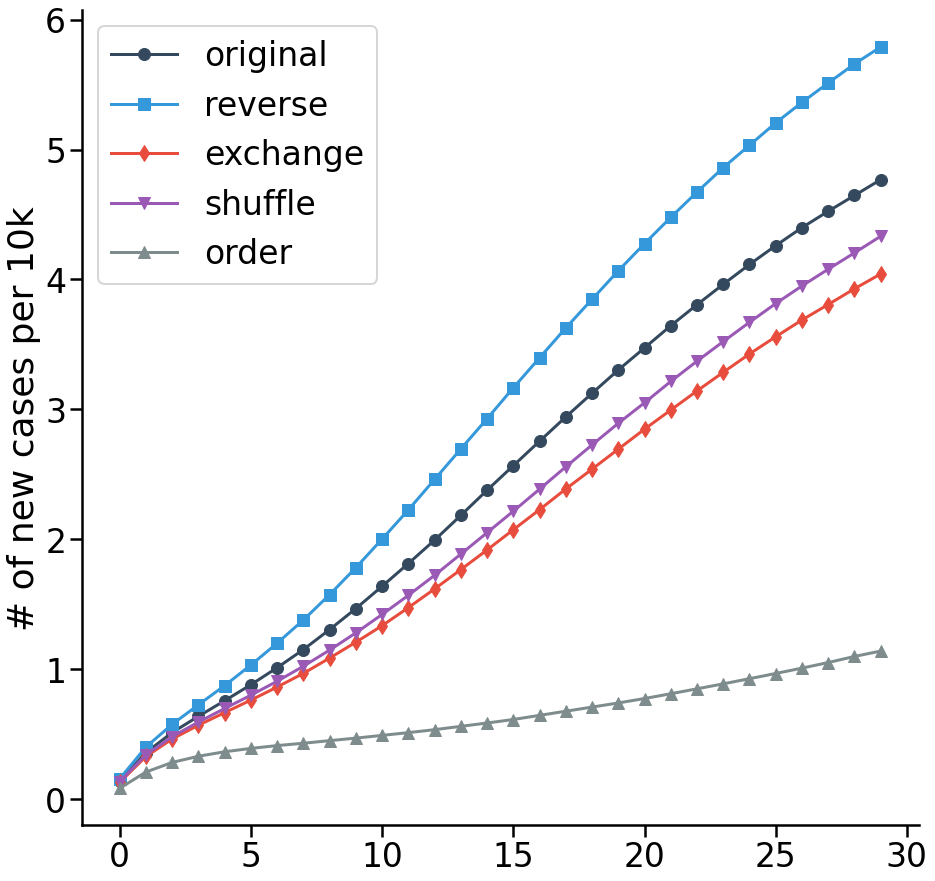

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#34495e', '#3498db', '#e74c3c', '#9b59b6', '#7f8c8d'])

markers = ['o', 's', 'd', 'v', '^']

mi = 0
for key in ['original', 
            'reverse_within', 
            'exchange', 
            'shuffle', 
            'order',
           ]:
    plt.errorbar(range(30), 
                 [results[key][:, 24*d:24*(d+1)].sum(axis=1).mean() / total_pop * 10000 for d in range(30)], 
                 label=key.split('_')[0],
                 marker=markers[mi])
    mi += 1

plt.legend()
plt.ylabel('# of new cases per 10k')

sns.despine()
plt.savefig('../results/US_simulation.pdf')

In [ ]:
! python US_simulation-track-12-2022.py --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --efficacy=0.7





[0.38576656 0.45429543 0.44505154 ... 0.62518646 0.54681183 0.62338314]
[0.38576656 0.45429543 0.44505154 ... 0.62518646 0.54681183 0.62338314]
Adjusted POI transmission rates with dwell time correction factors
Received POI_CBG_VISITS_LIST, will NOT be computing hourly matrices on the fly
=== PARAMETERS ===
poi_psi = 120000000.0, home_beta = 0.005, p_sick_at_t0 = 0.001, num_hours = 720
POI factors (psi * dwell_time_factor / area) for first 10 POIs
[ 512.40367055 5526.4306578   425.07302193 8225.29473973  162.61122145
  563.69785795  563.90307907 2146.31156146  141.72951108 5931.19810202]
simulating confirmed cases: True, simulating deaths: True
=== RESULTS (25 seeds) ===
t=  0: L=212834.0 (330.1)   I=  0.0 (  0.0)   R=102469613.0 (  0.0)
t= 24: L=191002.8 (314.4)   I=26753.8 (173.5)   R=101339661.4 (1268.3)
t= 48: L=185274.2 (332.6)   I=45616.0 (185.0)   R=100226588.5 (1673.4)
t= 72: L=189839.8 (446.6)   I=61007.6 (246.8)   R=99129443.8 (1916.0)
t= 96: L=202120.2 (521.5)   I=75562.1 (2

In [1]:
import numpy as np

In [2]:
results1 = np.load('../results/results_all_original_720_intervene_0_120000000_0.46_2022.npy', allow_pickle=True).item()
results1 = results1[(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original']


In [5]:
results2 = np.load('../results/results_all_original_720_intervene_0_120000000_0.46_2022_natural_imm.npy', allow_pickle=True).item()
results2 = results2[(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original']

In [6]:
results0 = np.load('../results/results_all_original_720_intervene_0_120000000_0.46.npy', allow_pickle=True).item()
results0 = results0[(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original']

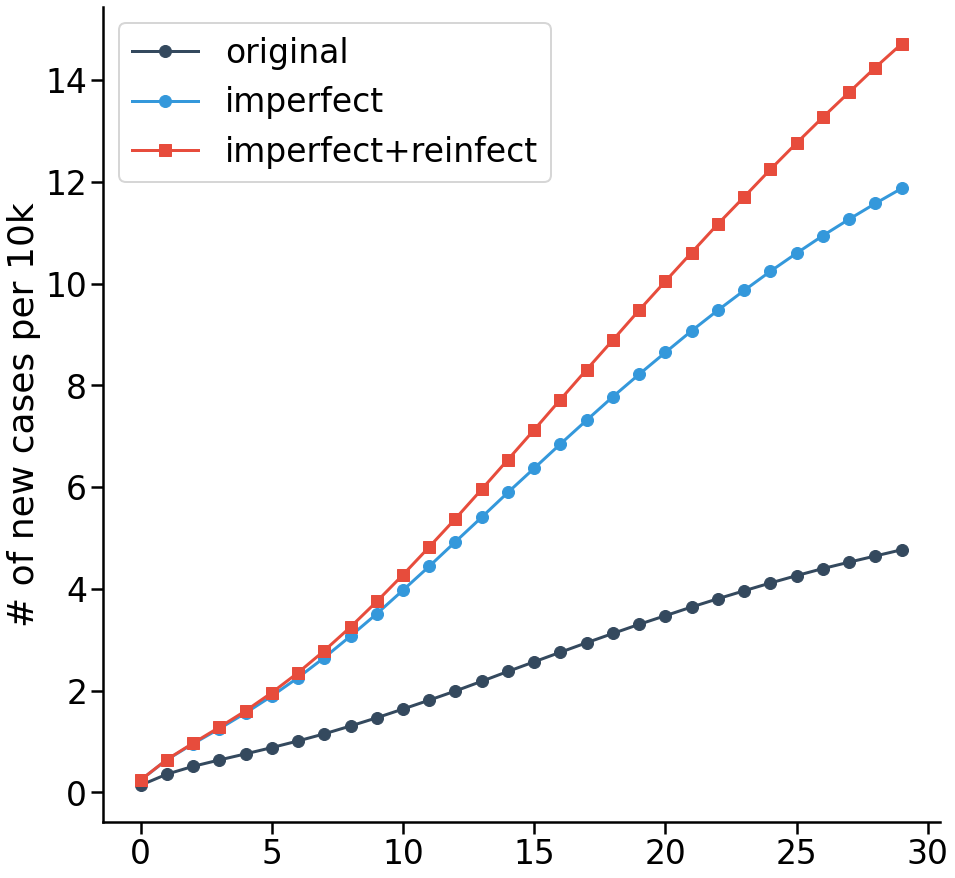

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#34495e', '#3498db', '#e74c3c', '#9b59b6', '#7f8c8d'])

markers = ['o', 's', 'd', 'v', '^']


mi = 0
for key in ['original']:
    plt.errorbar(range(30), 
                 [results0['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results0['all']['total_pop'] * 10000 for d in range(30)], 
                 label='original',
                 marker=markers[mi])
    mi += 1

mi = 0
for key in ['original']:
    plt.errorbar(range(30), 
                 [results1['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results0['all']['total_pop'] * 10000 for d in range(30)], 
                 label='imperfect',
                 marker=markers[mi])
    mi += 1

for key in ['original']:
    plt.errorbar(range(30), 
                 [results2['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results0['all']['total_pop'] * 10000 for d in range(30)], 
                 label='imperfect+reinfect',
                 marker=markers[mi])
    mi += 1

plt.legend()
plt.ylabel('# of new cases per 10k')

sns.despine()

In [15]:
results[(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original']['all']['new_cases'].mean(axis=0)

array([    0.  ,    30.36,    62.2 ,    93.  ,   121.04,   157.08,
         183.64,   204.44,   236.88,   268.  ,   284.8 ,   311.44,
         341.76,   361.88,   384.56,   414.2 ,   442.  ,   470.24,
         489.28,   508.56,   528.44,   554.8 ,   577.84,   596.72,
         617.4 ,   642.88,   650.96,   678.12,   705.12,   723.72,
         738.48,   762.4 ,   782.  ,   806.96,   809.92,   844.8 ,
         853.84,   871.72,   892.56,   914.08,   935.44,   947.08,
         966.68,   973.76,  1003.28,  1012.72,  1037.88,  1047.08,
        1075.6 ,  1083.8 ,  1100.64,  1096.56,  1130.88,  1158.28,
        1163.08,  1190.36,  1198.72,  1219.48,  1227.64,  1254.6 ,
        1266.64,  1285.88,  1302.44,  1310.52,  1347.36,  1345.32,
        1363.32,  1382.96,  1384.96,  1419.92,  1434.88,  1433.56,
        1456.12,  1478.28,  1474.28,  1508.8 ,  1524.48,  1546.2 ,
        1560.96,  1571.36,  1590.84,  1595.84,  1624.8 ,  1624.84,
        1644.2 ,  1669.6 ,  1684.64,  1703.04,  1722.56,  1734

In [ ]:
! python US_simulation-track-12-2022.py --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --efficacy=0.7
! python US_simulation-track-12-2022.py --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --efficacy=0.7


In [1]:
import numpy as np

results = {}

In [2]:
results['original'] = np.load('../results/results_all_original_720_intervene_0_120000000_0.46_2022_natural_imm.npy', allow_pickle=True).item()
results['original'] = results['original']

results['reverse_within'] = np.load('../results/results_all_reverse_within_720_intervene_0_120000000_0.46_2022_natural_imm.npy', allow_pickle=True).item()
results['reverse_within'] = results['reverse_within']

results['exchange'] = np.load('../results/results_all_exchange_720_intervene_0_120000000_0.46_2022_natural_imm.npy', allow_pickle=True).item()
results['exchange'] = results['exchange']

results['shuffle'] = np.load('../results/results_all_shuffle_720_intervene_0_120000000_0.46_2022_natural_imm.npy', allow_pickle=True).item()
results['shuffle'] = results['shuffle']

results['order'] = np.load('../results/results_all_order_720_intervene_0_120000000_0.46_2022_natural_imm.npy', allow_pickle=True).item()
results['order'] = results['order']

In [7]:
for key in results:
    results[key] = results[key][(-1.0, 0.001, 0.005, 120000000.0, 720, False)][key]

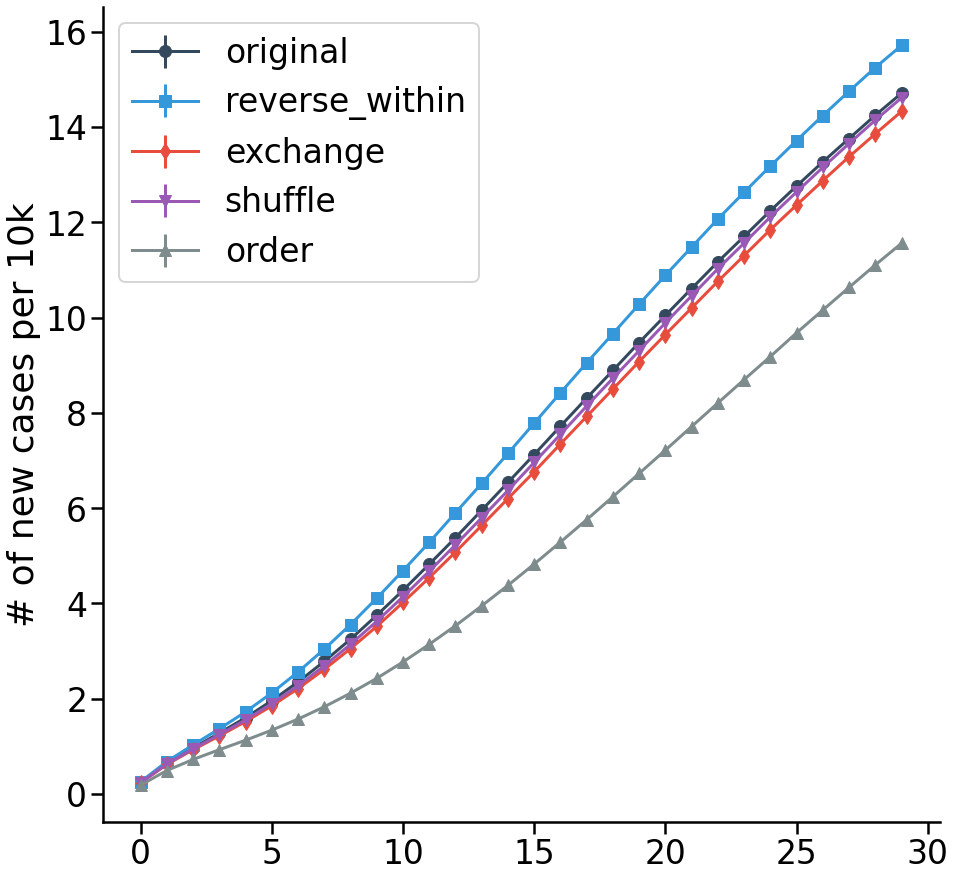

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#34495e', '#3498db', '#e74c3c', '#9b59b6', '#7f8c8d'])

markers = ['o', 's', 'd', 'v', '^']


mi = 0
for key in ['original', 'reverse_within', 'exchange', 'shuffle', 'order']:
    plt.errorbar(range(30), 
                 [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).std() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 label=key,
                 marker=markers[mi])
    mi += 1

plt.legend()
plt.ylabel('# of new cases per 10k')

sns.despine()

In [14]:
[results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results[key]['all']['total_pop'] * 10000 for d in range(30)], [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).std() / results[key]['all']['total_pop'] * 10000 for d in range(30)]

([0.18865515749637235,
  0.4947716176921439,
  0.7268074203597037,
  0.9312493444829465,
  1.1304831062785965,
  1.3421363320861983,
  1.5741632600857218,
  1.8318417821393307,
  2.1176606087263488,
  2.4298688946241858,
  2.772877349846885,
  3.1434961651402538,
  3.533688694692558,
  3.950841197929442,
  4.380564034534896,
  4.8279563352006365,
  5.288925610152207,
  5.759047203468649,
  6.241163544541019,
  6.729972653122484,
  7.218452131176887,
  7.713923579834179,
  8.207640379839722,
  8.69805453552604,
  9.183141354771132,
  9.680116425755722,
  10.158190989442414,
  10.634419622177553,
  11.10501284070964,
  11.560675064175499],
 [0.0029611117534141,
  0.004881466846012859,
  0.005685559936043804,
  0.007324527923094379,
  0.008498645549840535,
  0.0077141636552014526,
  0.009940101192398137,
  0.011081150570657878,
  0.012762543677004183,
  0.014005427808793032,
  0.012393464169544371,
  0.01826374621124027,
  0.016156002947679448,
  0.019301421223774706,
  0.0189639021065242

In [ ]:
!parallel --jobs 5 < run-nation-2022.sh 

Academic tradition requires you to cite works you base your article on.
When using programs that use GNU Parallel to process data for publication
please cite:

  O. Tange (2011): GNU Parallel - The Command-Line Power Tool,
  ;login: The USENIX Magazine, February 2011:42-47.

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

To silence this citation notice: run 'parallel --citation'.



In [20]:
import numpy as np

results = {}

In [21]:
import numpy as np

results = {}

results['original'] = np.load('../results/results_all_original_720_intervene_0_120000000_0.46_2022_natural_imm_perfect.npy', allow_pickle=True).item()
results['original'] = results['original']

results['reverse_within'] = np.load('../results/results_all_reverse_within_720_intervene_0_120000000_0.46_2022_natural_imm_perfect.npy', allow_pickle=True).item()
results['reverse_within'] = results['reverse_within']

results['exchange'] = np.load('../results/results_all_exchange_720_intervene_0_120000000_0.46_2022_natural_imm_perfect.npy', allow_pickle=True).item()
results['exchange'] = results['exchange']

results['shuffle'] = np.load('../results/results_all_shuffle_720_intervene_0_120000000_0.46_2022_natural_imm_perfect.npy', allow_pickle=True).item()
results['shuffle'] = results['shuffle']

results['order'] = np.load('../results/results_all_order_720_intervene_0_120000000_0.46_2022_natural_imm_perfect.npy', allow_pickle=True).item()
results['order'] = results['order']

In [22]:
for key in results:
    results[key] = results[key][(-1.0, 0.001, 0.005, 120000000.0, 720, False)][key]

In [ ]:
!python US_simulation-track-12-2022.py --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=reverse_within --efficacy=1.0

[0.65206644 0.58353757 0.59278146 ... 0.45826632 0.53664095 0.46006964]
[0.65206644 0.58353757 0.59278146 ... 0.45826632 0.53664095 0.46006964]
Adjusted POI transmission rates with dwell time correction factors
Received POI_CBG_VISITS_LIST, will NOT be computing hourly matrices on the fly
=== PARAMETERS ===
poi_psi = 120000000.0, home_beta = 0.005, p_sick_at_t0 = 0.001, num_hours = 720
POI factors (psi * dwell_time_factor / area) for first 10 POIs
[ 512.40367055 5526.4306578   425.07302193 8225.29473973  162.61122145
  563.69785795  563.90307907 2146.31156146  141.72951108 5931.19810202]
simulating confirmed cases: True, simulating deaths: True
=== RESULTS (25 seeds) ===
t=  0: L=168873.2 (289.0)   I=  0.0 (  0.0)   R=146459374.0 (  0.0)
t= 24: L=153277.4 (288.1)   I=18765.2 (176.1)   R=144842489.5 (1331.2)
t= 48: L=148615.3 (350.8)   I=31933.2 (210.4)   R=143246507.1 (1835.6)
t= 72: L=151106.4 (474.8)   I=42500.3 (285.5)   R=141671011.8 (2249.9)
t= 96: L=158845.8 (533.4)   I=52354.5 (

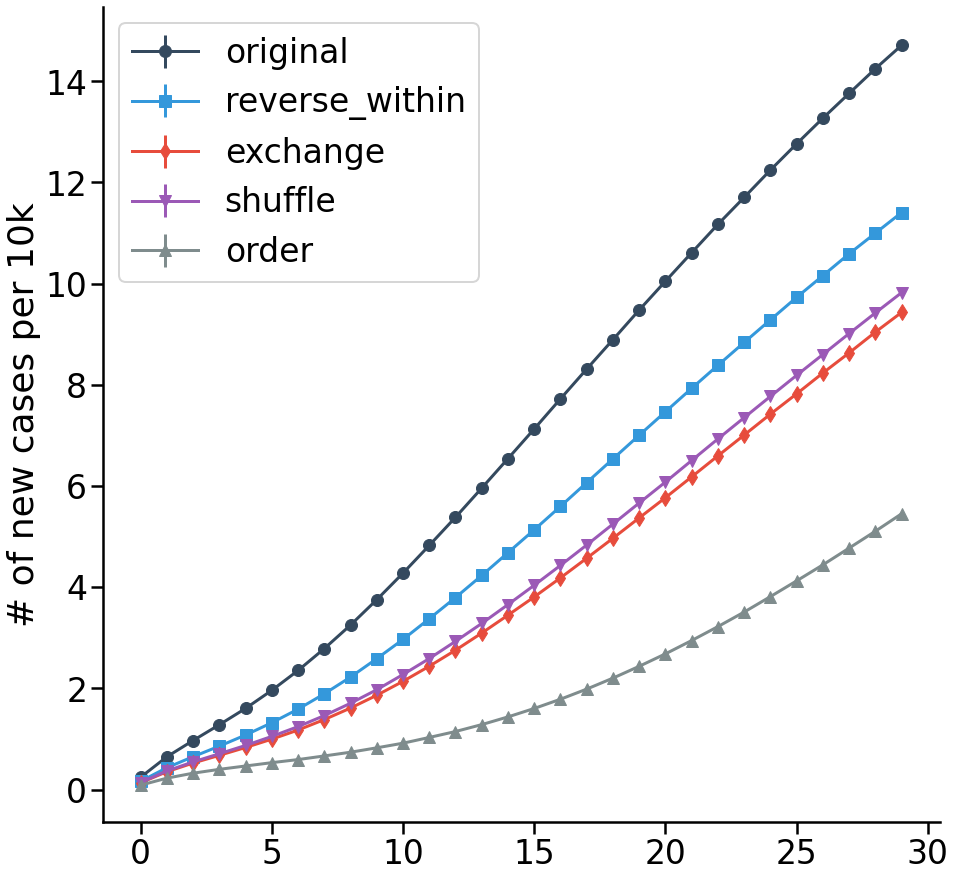

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#34495e', '#3498db', '#e74c3c', '#9b59b6', '#7f8c8d'])

markers = ['o', 's', 'd', 'v', '^']


mi = 0
for key in ['original', 'reverse_within', 'exchange', 'shuffle', 'order']:
    plt.errorbar(range(30), 
                 [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).std() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 label=key,
                 marker=markers[mi])
    mi += 1

plt.legend()
plt.ylabel('# of new cases per 10k')

sns.despine()

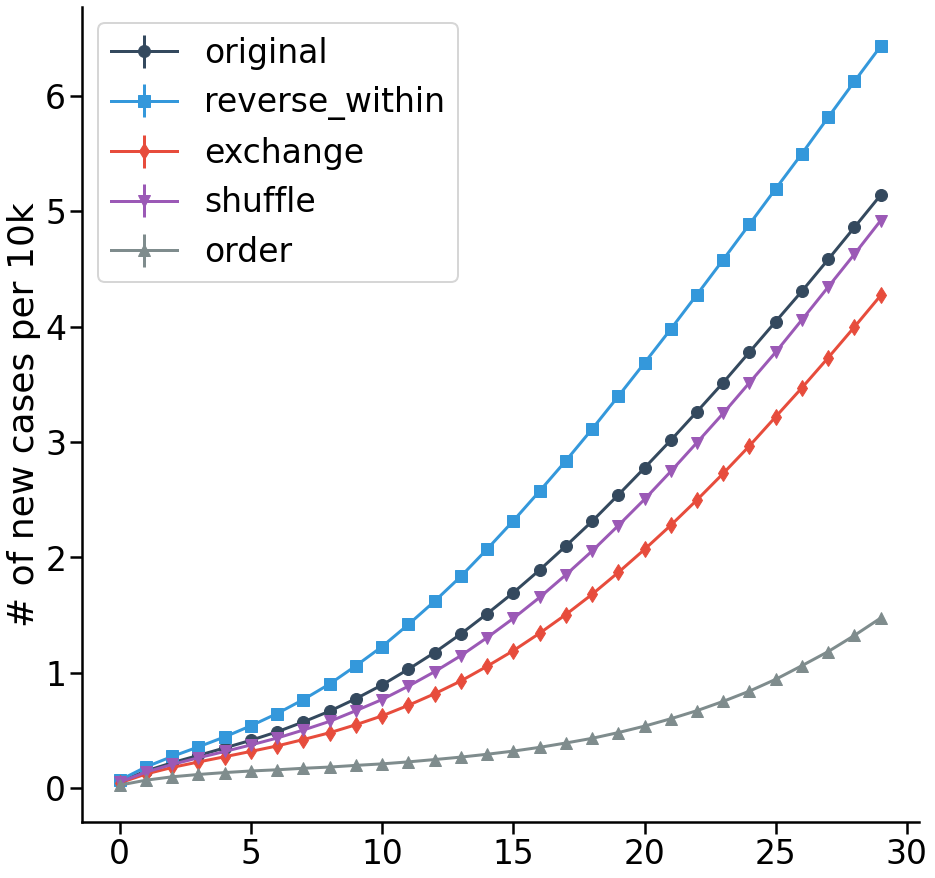

In [27]:
import numpy as np

results = {}

results['original'] = np.load('../results/results_all_original_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_1.000000.npy', allow_pickle=True).item()
results['original'] = results['original']

results['reverse_within'] = np.load('../results/results_all_reverse_within_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_1.000000.npy', allow_pickle=True).item()
results['reverse_within'] = results['reverse_within']

results['exchange'] = np.load('../results/results_all_exchange_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_1.000000.npy', allow_pickle=True).item()
results['exchange'] = results['exchange']

results['shuffle'] = np.load('../results/results_all_shuffle_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_1.000000.npy', allow_pickle=True).item()
results['shuffle'] = results['shuffle']

results['order'] = np.load('../results/results_all_order_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_1.000000.npy', allow_pickle=True).item()
results['order'] = results['order']

for key in results:
    results[key] = results[key][(-1.0, 0.001, 0.005, 120000000.0, 720, False)][key]
    
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#34495e', '#3498db', '#e74c3c', '#9b59b6', '#7f8c8d'])

markers = ['o', 's', 'd', 'v', '^']


mi = 0
for key in ['original', 'reverse_within', 'exchange', 'shuffle', 'order']:
    plt.errorbar(range(30), 
                 [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).std() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 label=key,
                 marker=markers[mi])
    mi += 1

plt.legend()
plt.ylabel('# of new cases per 10k')

sns.despine()

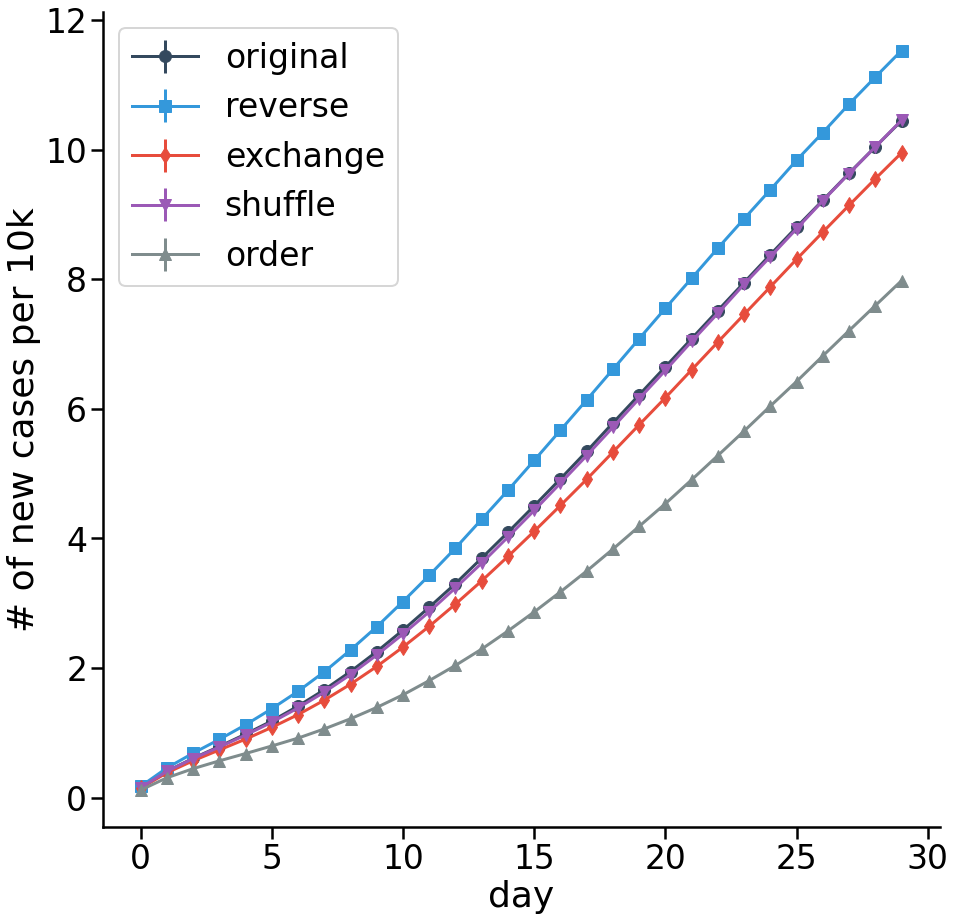

In [4]:
import numpy as np

results = {}

results['original'] = np.load('../results/results_all_original_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_0.700000.npy', allow_pickle=True).item()
results['original'] = results['original']

results['reverse_within'] = np.load('../results/results_all_reverse_within_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_0.700000.npy', allow_pickle=True).item()
results['reverse_within'] = results['reverse_within']

results['exchange'] = np.load('../results/results_all_exchange_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_0.700000.npy', allow_pickle=True).item()
results['exchange'] = results['exchange']

results['shuffle'] = np.load('../results/results_all_shuffle_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_0.700000.npy', allow_pickle=True).item()
results['shuffle'] = results['shuffle']

results['order'] = np.load('../results/results_all_order_720_intervene_0_120000000_0.63_2022_new_natural_imm_perfect_0.700000.npy', allow_pickle=True).item()
results['order'] = results['order']

for key in results:
    results[key] = results[key][(-1.0, 0.001, 0.005, 120000000.0, 720, False)][key]
    
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#34495e', '#3498db', '#e74c3c', '#9b59b6', '#7f8c8d'])

markers = ['o', 's', 'd', 'v', '^']
labels = ['original', 'reverse', 'exchange', 'shuffle', 'order']

mi = 0
for key in ['original', 'reverse_within', 'exchange', 'shuffle', 'order']:
    plt.errorbar(range(30), 
                 [results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).mean() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 yerr=[results[key]['all']['new_cases'][:, 24*d:24*(d+1)].sum(axis=1).std() / results[key]['all']['total_pop'] * 10000 for d in range(30)], 
                 label=labels[mi],
                 marker=markers[mi]
                )
    mi += 1

plt.legend()
plt.ylabel('# of new cases per 10k')

sns.despine()

plt.xlabel('day')

plt.savefig('../results/US_simulation_2022.pdf')

In [14]:
for key in results:
    print(key, results[key]['all']['new_cases'].mean(axis=0).sum())

original 4431862.4399999995
reverse_within 5017621.04
exchange 4127133.04
shuffle 4396689.4399999995
order 3084774.2800000003


In [1]:
import numpy as np
import pandas as pd

In [2]:
vax_distribution = np.load('../results/vax_distribution_by_state_2022.npy', allow_pickle=True).item()

In [3]:
bipartite_normed_products = {}

for state in vax_distribution:
    bipartite_normed_product = np.load('../../../../Sept/bipartite_normed_product_2022/bipartite_normed_product_%d.npy' % (state), allow_pickle=True)
    bipartite_normed_products[state] = bipartite_normed_product

In [12]:
all_text = """Alabama	AL	1
Alaska	AK	2
Arizona	AZ	4
Arkansas	AR	5
Colorado	CO	8
Connecticut	CT	9
Delaware	DE	10
District of Columbia	DC	11
Georgia	GA	13
Hawaii	HI	15
Idaho	ID	16
Illinois	IL	17
Indiana	IN	18
Iowa	IA	19
Kansas	KS	20
Kentucky	KY	21
Louisiana	LA	22
Maine	ME	23
Maryland	MD	24
Massachusetts	MA	25
Michigan	MI	26
Minnesota	MN	27
Mississippi	MS	28
Missouri	MO	29
Montana	MT	30
Nebraska	NE	31
Nevada	NV	32
New Hampshire	NH	33
New Jersey	NJ	34
New Mexico	NM	35
North Carolina	NC	37
North Dakota	ND	38
Ohio	OH	39
Oklahoma	OK	40
Oregon	OR	41
Pennsylvania	PA	42
Rhode Island	RI	44
South Carolina	SC	45
South Dakota	SD	46
Tennessee	TN	47
Utah	UT	49
Vermont	VT	50
Virginia	VA	51
Washington	WA	53
West Virginia	WV	54
Wisconsin	WI	55
Wyoming	WY	56
Texas	TX	48
California	CA	6
New York	NY	36
New Jersey	NJ	34
Florida	FL	12"""

code2state = {}

for line in all_text.split('\n'):
    items = [item for item in line.split('\t')]
    code2state[int(items[2])] = items[0]

In [30]:
data_vax = []

for state in vax_distribution:
    for i in range(len(vax_distribution[state])):
        is_in = code2state[state] in ['California', 'Texas', 'New York', 'New Jersey', 'Florida', 'Michigan', 'Georgia', 'North Carolina', 'Ohio', 'Illinois']
        data_point = {
            'state_code': state,
            'State': code2state[state],
            'log centrality': np.log10(bipartite_normed_products[state][i]),
            'vaccination rate': vax_distribution[state]['original'][i],
            'exchanged vaccination rate': vax_distribution[state]['exchange'][i],
            'populated_10': is_in
        }
        data_vax.append(data_point)
        
data_vax = pd.DataFrame.from_dict(data_vax)

In [25]:
data_vax

,state_code,State,log centrality,vaccination rate,exchanged vaccination rate,populated_10
0,42,Pennsylvania,163.495007,0.626308,0.345161,False
1,42,Pennsylvania,1106.554979,0.830614,0.694987,False
2,42,Pennsylvania,1329.246187,0.827049,0.652999,False
3,42,Pennsylvania,985.356033,0.804766,0.626842,False
4,42,Pennsylvania,633.743185,0.588315,0.522638,False
...,...,...,...,...,...,...
245,48,Texas,1948.565020,0.372534,0.415967,True
246,48,Texas,918.689953,0.497937,0.493181,True
247,48,Texas,450.609360,0.512189,0.441629,True
248,48,Texas,1245.759055,0.537644,0.544238,True


In [29]:
data_vax['']

,state_code,State,log centrality,vaccination rate,exchanged vaccination rate,populated_10
0,42,Pennsylvania,163.495007,0.626308,0.345161,False
1,42,Pennsylvania,1106.554979,0.830614,0.694987,False
2,42,Pennsylvania,1329.246187,0.827049,0.652999,False
3,42,Pennsylvania,985.356033,0.804766,0.626842,False
4,42,Pennsylvania,633.743185,0.588315,0.522638,False
...,...,...,...,...,...,...
245,48,Texas,1948.565020,0.372534,0.415967,True
246,48,Texas,918.689953,0.497937,0.493181,True
247,48,Texas,450.609360,0.512189,0.441629,True
248,48,Texas,1245.759055,0.537644,0.544238,True


In [ ]:
import statsmodels.api as sm

sm.OLS()

<Figure size 1440x1440 with 0 Axes>

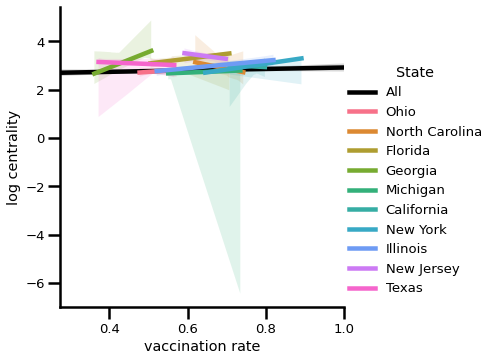

In [31]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.set_context('poster', font_scale=0.6)
colors = sns.color_palette("husl", 10)

tmp_data_vax = copy.deepcopy(data_vax)
tmp_data_vax['State'] = 'All'
tmp = pd.concat([tmp_data_vax, data_vax[data_vax['populated_10']]])

sns.lmplot(data=tmp, x='vaccination rate', y='log centrality', order=1, scatter=False, hue='State', palette=[(0, 0, 0)] + colors)

plt.savefig('centrality_illustration.pdf')

In [ ]:
sns.lmplot(data=tmp, x='vaccination rate', y='exchanged vaccination rate', order=1, scatter=False, hue='State', palette=[(0, 0, 0)] + colors)
